In [1]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!kaggle datasets download -d paultimothymooney/breast-histopathology-images

100% 3.08G/3.10G [00:27<00:00, 193MB/s]
100% 3.10G/3.10G [00:27<00:00, 119MB/s]


In [4]:
!mkdir dataset

In [5]:
!ls

breast-histopathology-images.zip  dataset  kaggle.json	sample_data


In [6]:
!unzip -q breast-histopathology-images.zip -d dataset

# Setup

In [1]:
import numpy as np
import glob
import random
import warnings
warnings.filterwarnings(action = 'ignore')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from glob import glob

from PIL import Image

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from glob import glob
from os import listdir

import time
import copy
from tqdm import tqdm_notebook as tqdm


import tensorflow as tf

random.seed(98)
np.random.seed(98)

In [2]:
samples = glob('dataset/IDC_regular_ps50_idx5/**/*.png', recursive= True)

samples[:3]

['dataset/IDC_regular_ps50_idx5/8865/0/8865_idx5_x351_y1201_class0.png',
 'dataset/IDC_regular_ps50_idx5/8865/0/8865_idx5_x701_y651_class0.png',
 'dataset/IDC_regular_ps50_idx5/8865/0/8865_idx5_x751_y851_class0.png']

In [3]:
IDC_negative = []
IDC_positive = []

for img in samples:
  if img[-5] == '0':
    IDC_negative.append(img)
  else:
    IDC_positive.append(img)

print('Negative samples: ', IDC_negative[:3])
print('Positive samples: ', IDC_positive[:3])
print('Negative sample size: ', len(IDC_negative))
print('Positive sample size: ', len(IDC_positive))

Negative samples:  ['dataset/IDC_regular_ps50_idx5/8865/0/8865_idx5_x351_y1201_class0.png', 'dataset/IDC_regular_ps50_idx5/8865/0/8865_idx5_x701_y651_class0.png', 'dataset/IDC_regular_ps50_idx5/8865/0/8865_idx5_x751_y851_class0.png']
Positive samples:  ['dataset/IDC_regular_ps50_idx5/8865/1/8865_idx5_x1951_y1001_class1.png', 'dataset/IDC_regular_ps50_idx5/8865/1/8865_idx5_x1851_y551_class1.png', 'dataset/IDC_regular_ps50_idx5/8865/1/8865_idx5_x1751_y551_class1.png']
Negative sample size:  198738
Positive sample size:  78786


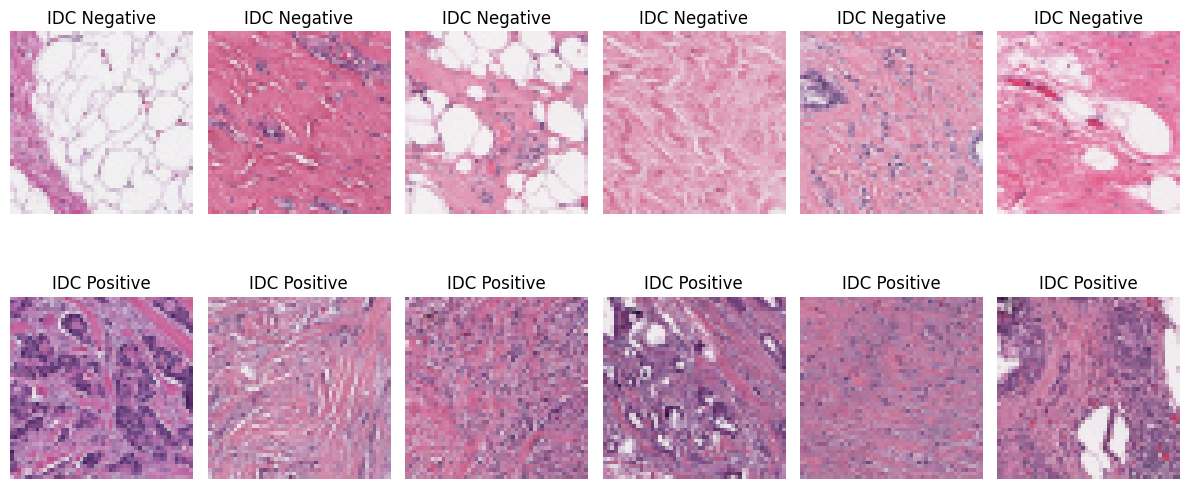

In [4]:
# Randomly select a few IDC negative and positive samples for display
sample_size = 6  # You can change this to the number of samples you want to display
random_negative_samples = random.sample(IDC_negative, sample_size)
random_positive_samples = random.sample(IDC_positive, sample_size)

# Create subplots for IDC negative patches
plt.figure(figsize=(12, 6))
for i in range(sample_size):
    plt.subplot(2, sample_size, i + 1)
    img = mpimg.imread(random_negative_samples[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title('IDC Negative')

# Create subplots for IDC positive patches
for i in range(sample_size):
    plt.subplot(2, sample_size, i + sample_size + 1)
    img = mpimg.imread(random_positive_samples[i])
    plt.imshow(img)
    plt.axis('off')
    plt.title('IDC Positive')

plt.tight_layout()
plt.show()

In [5]:
from PIL import Image
import numpy as np

# Define the image size
IMG_SIZE = (96, 96)
INPUT_SHAPE = (96, 96, 3)
# Define the number of samples to use from each class
NUM_SAMPLES_PER_CLASS = 5000

# Define lists to store features (X) and labels (y)
X = []
y = []

# Define a function to extract features and labels
def extract_features_labels(sample_paths, label_value):
    count = 0
    for path in sample_paths:
        if count >= NUM_SAMPLES_PER_CLASS:
            break
        img = Image.open(path).resize(IMG_SIZE, Image.LANCZOS)
        X.append(np.array(img) / 255.0)
        y.append(label_value)
        count += 1

# Extract features and labels for IDC negative samples (up to 20,000)
extract_features_labels(IDC_negative, label_value=0)

# Extract features and labels for IDC positive samples (up to 20,000)
extract_features_labels(IDC_positive, label_value=1)

# Convert lists to NumPy arrays
X = np.array(X)
y = np.array(y)

# Shuffle the data
shuffled_indices = np.arange(len(y))
np.random.shuffle(shuffled_indices)
X = X[shuffled_indices]
y = y[shuffled_indices]

# Check the shape of the features and labels arrays
print("Features shape:", X.shape)
print("Labels shape:", y.shape)


Features shape: (10000, 96, 96, 3)
Labels shape: (10000,)


In [6]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Split the data into train, test, and predict sets
X_train, X_predict, y_train, y_true = train_test_split(X, y, test_size=0.3, random_state=7)

# Define the ratio for reducing the size of the train and test sets
rate = 0.5
num = int(X.shape[0] * rate)

# Reduce the size of the train and test sets
X_test = X_train[num:]
X_train = X_train[:num]

y_test = y_train[num:]
y_train = y_train[:num]

# Convert labels to categorical format
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_true = to_categorical(y_true, 2)

# Print the shapes of the datasets
print('X_train shape: {}'.format(X_train.shape))
print('X_test shape: {}'.format(X_test.shape))
print('X_predict shape: {}'.format(X_predict.shape))
print('y_train shape: {}'.format(y_train.shape))
print('y_test shape: {}'.format(y_test.shape))
print('y_true shape: {}'.format(y_true.shape))


X_train shape: (5000, 96, 96, 3)
X_test shape: (2000, 96, 96, 3)
X_predict shape: (3000, 96, 96, 3)
y_train shape: (5000, 2)
y_test shape: (2000, 2)
y_true shape: (3000, 2)


In [7]:
base_model = tf.keras.applications.VGG16(weights='imagenet', include_top=False)  # Exclude the top fully connected layers

In [8]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D

# Load the pre-trained MobileNetV2 model with custom classification layers
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=INPUT_SHAPE)

# Create a Sequential model for your custom classification task
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(2, activation='softmax')
])

# Freeze the base model layers
for layer in base_model.layers:
    layer.trainable = False

# Print the summary of the model
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_96 (Funct  (None, 3, 3, 1280)        2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 2586434 (9.87 MB)
Trainable params: 328450 (1.25 MB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [9]:
from keras.optimizers import Adam

Adam = Adam(learning_rate = 0.0001)
model.compile(loss = 'binary_crossentropy', optimizer = Adam, metrics = ['accuracy'])

# Model Train

In [10]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',   # Metric to monitor (e.g., validation loss)
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    verbose=1,            # Verbosity mode (0: quiet, 1: update messages)
    restore_best_weights=True  # Restore model weights from the epoch with the best value of the monitored metric
)

In [11]:
history = model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 30, batch_size = 32, callbacks=[early_stopping])

Epoch 1/30
157/157 [==============================] - 18s 35ms/step - loss: 0.4188 - accuracy: 0.8228 - val_loss: 0.3667 - val_accuracy: 0.8510
Epoch 2/30
157/157 [==============================] - 3s 22ms/step - loss: 0.3123 - accuracy: 0.8722 - val_loss: 0.3179 - val_accuracy: 0.8785
Epoch 3/30
157/157 [==============================] - 3s 18ms/step - loss: 0.2777 - accuracy: 0.8882 - val_loss: 0.2982 - val_accuracy: 0.8850
Epoch 4/30
157/157 [==============================] - 3s 19ms/step - loss: 0.2559 - accuracy: 0.8982 - val_loss: 0.2982 - val_accuracy: 0.8830
Epoch 5/30
157/157 [==============================] - 3s 18ms/step - loss: 0.2372 - accuracy: 0.9072 - val_loss: 0.2787 - val_accuracy: 0.8945
Epoch 6/30
157/157 [==============================] - 4s 23ms/step - loss: 0.2225 - accuracy: 0.9150 - val_loss: 0.2743 - val_accuracy: 0.8890
Epoch 7/30
157/157 [==============================] - 4s 24ms/step - loss: 0.2086 - accuracy: 0.9244 - val_loss: 0.2694 - val_accuracy: 0.893

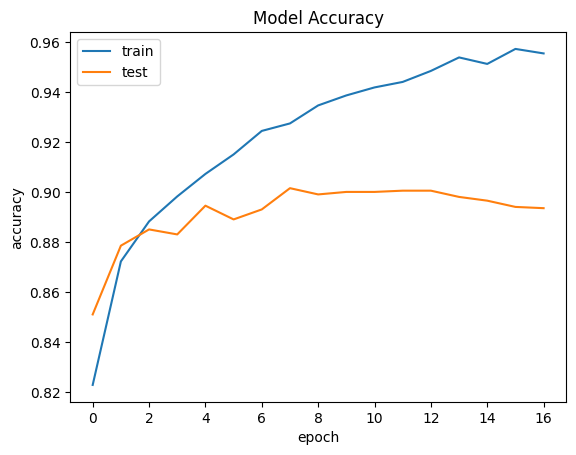

In [12]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

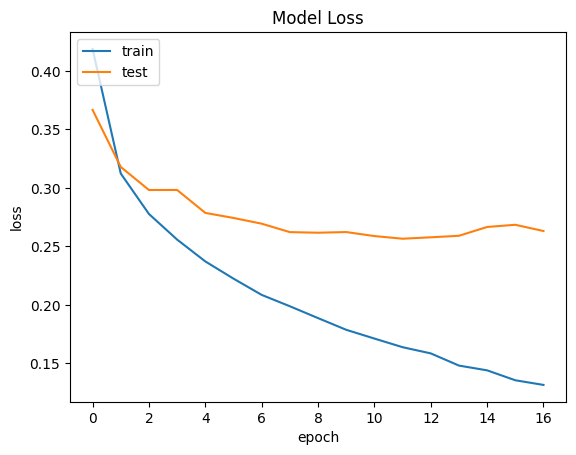

In [13]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

94/94 [==============================] - 2s 11ms/step
Accuracy: 0.9100
Precision: 0.9137
Recall: 0.9052
F1 Score: 0.9095


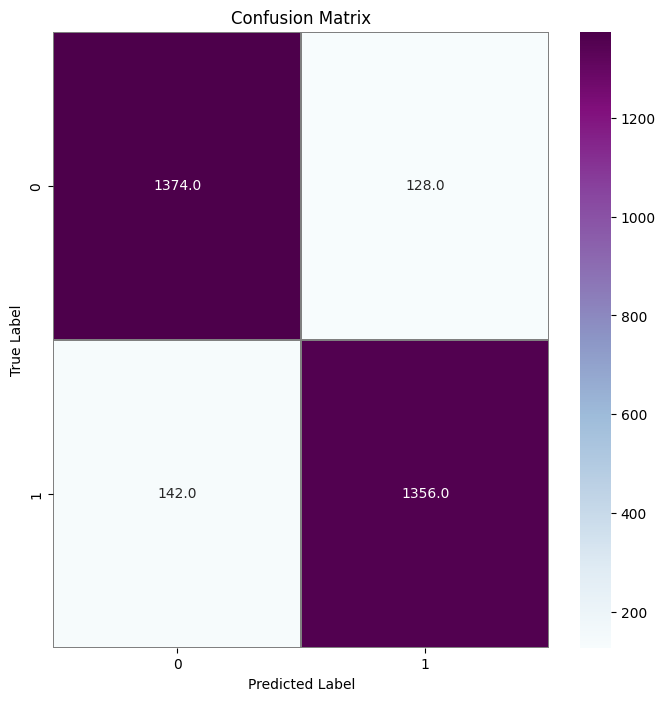

In [16]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns

# Split the data into train, test, and predict sets
X_train, X_predict, y_train, y_true = train_test_split(X, y, test_size=0.3, random_state=7)

# Define the ratio for reducing the size of the train and test sets
rate = 0.5
num = int(X_train.shape[0] * rate)

# Reduce the size of the train and test sets
X_test = X_train[num:]
X_train = X_train[:num]

y_test = y_train[num:]
y_train = y_train[:num]

# Convert labels to categorical format
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_true = to_categorical(y_true, 2)

# Assuming you have predicted labels
predicted_labels = model.predict(X_predict)

# Calculate accuracy
accuracy = accuracy_score(y_true.argmax(axis=1), predicted_labels.argmax(axis=1))

# Calculate precision, recall, and F1-score
precision = precision_score(y_true.argmax(axis=1), predicted_labels.argmax(axis=1), average='binary')
recall = recall_score(y_true.argmax(axis=1), predicted_labels.argmax(axis=1), average='binary')
f1 = f1_score(y_true.argmax(axis=1), predicted_labels.argmax(axis=1), average='binary')
conf_matrix = confusion_matrix(y_true.argmax(axis=1), predicted_labels.argmax(axis=1))

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, linewidths=0.01, cmap="BuPu", linecolor="gray", fmt='.1f')
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()